In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# 导入sklearn模拟二分类数据生成模块
from sklearn.datasets._samples_generator import make_blobs

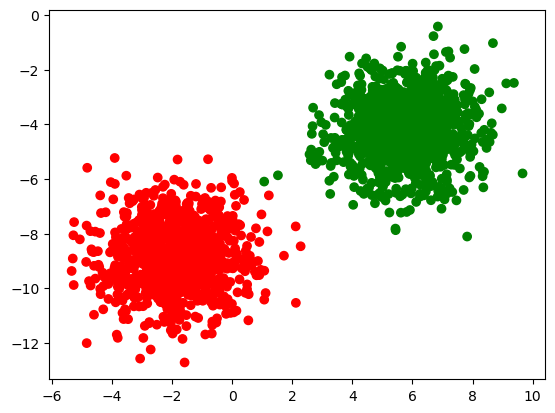

In [18]:

# 生成模拟二分类数据集
X, y =  make_blobs(n_samples=2000, n_features=2, centers=2,
  cluster_std=1.2, random_state=40)
# 将标签转换为1/-1
y_ = y.copy()
y_[y_==0] = -1
y_ = y_.astype(float)
# 训练/测试数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y_,
 test_size=0.3, random_state=43)
# 设置颜色参数
colors = {0:'r', 1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X[:,0], X[:,1], marker='o', c=pd.Series(y).map(colors))
plt.show()

In [19]:
class DecisionStump():
    ''' 
    Decision tree桩类
    作为AdaBoost的弱分类器
    '''
    def __init__(self):
        # 基于threshold决定样本分类
        self.label = 1
        # 特征index
        self.feature_index = None
        # Threshold
        self.threshold = None
        # 指示分类准确率的值
        self.alpha = None

class Adaboost:
    ''' 
    AdaBoost实现
    '''
    def __init__(self, n_estimators = 5) -> None:
        self.n_estimators = n_estimators

    # adaboost拟合算法
    def fit(self, X, y):
        m,n = X.shape
        # 1. 初始化w为均匀分布与基分类器ls
        w = np.full(m,(1/m))
        self.estimators = []
        # 2. 
        for _ in range(self.n_estimators):
            # 2.1 训练一个弱分类器
            estimator = DecisionStump()
            # 设定最小化误差
            min_error = float('inf')
            # 遍历数据集特征，根据最小分类器误差率选择最优划分特征
            for i in range(n):
                # 获取特征值
                values = np.expand_dims(X[:,i], axis=1)
                # 特征值去重
                unique_values = np.unique(values)
                # 尝试将每一个特征值作为分类threshold
                for threshold in unique_values:
                    p = 1
                    # 初始化所有predict value的为1
                    pred = np.ones(np.shape(y))
                    # 小于threshold的预测值为-1
                    pred[X[:,i]<threshold] = -1
                    # 2.2 计算误差率
                    error = sum(w[y!=pred])
                    # 如果error>0.5: error = 0.6 -> error = 1-error = 0.4
                    if error>.5:
                        error = 1-error
                        p = -1  # 认为p是负的
                    # 获得了最小误差就保存相关参数配置, 可以理解为保存该基模型配置
                    if error < min_error:
                        estimator.label = p
                        estimator.threshold = threshold
                        estimator.feature_index = i
                        min_error = error

            # 2.3 计算基分类器权重
            estimator.alpha = 0.5*np.log((1.0-min_error)/(min_error+1e-9))
            # 初始化所有predict为1
            preds = np.ones(np.shape(y))
            # 获取所有小于threshold的负索引
            negative_idx = (estimator.label*X[:,estimator.feature_index]<estimator.label*estimator.threshold)
            # 将负类设为'-1'
            preds[negative_idx] = -1
            # 2.4 更新样本权重
            w *= np.exp(-estimator.alpha*y*preds)
            w /= np.sum(w)

            # 保存该弱分类器
            self.estimators.append(estimator)

    def predict(self, X):
        m = len(X)
        y_pred = np.zeros((m,1))
        # 计算每个弱分类器的预测值
        for estimator in self.estimators:
            # 初始化所有pred=1
            predictions = np.ones(np.shape(y_pred))
            # 获取所有小于threshold的负类idx
            negative_idx = (estimator.label * X[:, estimator.feature_index] < estimator.label * estimator.threshold)
            # 将负类设为-1
            predictions[negative_idx] = -1
            # 对每个弱分类器的结果加权（这也是boost的最后一步）
            y_pred += estimator.alpha*predictions
        
        y_pred = np.sign(y_pred).flatten()
        return y_pred

In [26]:
# 导入sklearn准确率计算函数
from sklearn.metrics import accuracy_score
# 创建Adaboost模型实例
clf = Adaboost(n_estimators=5)
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 计算模型预测准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of AdaBoost by numpy:", accuracy)

Accuracy of AdaBoost by numpy: 1.0


In [32]:
# 导入sklearn adaboost分类器
from sklearn.ensemble import AdaBoostClassifier
# 创建Adaboost模型实例
clf_ = AdaBoostClassifier(n_estimators=5, random_state=0)
# 模型拟合
clf_.fit(X_train, y_train)
# 模型预测
y_pred_ = clf_.predict(X_test)
# 计算模型预测准确率
accuracy = accuracy_score(y_test, y_pred_)
print("Accuracy of AdaBoost by sklearn:", accuracy)

Accuracy of AdaBoost by sklearn: 0.9983333333333333
